## Lila and Gabby: Regression {-}


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [108]:
#Lila's filepath for the movie dataset
#movies = pd.read_csv('Desktop/STAT3032/movie_metadata.csv')

#Gabby's filepath for the movie dataset:
movies = pd.read_csv('movie_metadata.csv')

In [109]:
movies.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [9]:
movies['language'].value_counts()
#The majority of the movies are in English...but we could do a comparison of success based on english vs not english.

English       4704
French          73
Spanish         40
Hindi           28
Mandarin        26
German          19
Japanese        18
Cantonese       11
Russian         11
Italian         11
Portuguese       8
Korean           8
Arabic           5
Danish           5
Hebrew           5
Swedish          5
Polish           4
Norwegian        4
Persian          4
Dutch            4
Thai             3
Chinese          3
Icelandic        2
None             2
Indonesian       2
Aboriginal       2
Romanian         2
Dari             2
Zulu             2
Panjabi          1
Urdu             1
Vietnamese       1
Slovenian        1
Greek            1
Dzongkha         1
Tamil            1
Telugu           1
Kannada          1
Czech            1
Hungarian        1
Bosnian          1
Filipino         1
Mongolian        1
Maya             1
Aramaic          1
Kazakh           1
Swahili          1
Name: language, dtype: int64

In [26]:
movies['plot_keywords'].value_counts()
#pick certain words that come up often... 'love', 'illegal','money', 'superhero'
#can we isolate each word, and then find the value counts from there?

string = "one,two,three"
words = string.split(',')
words

['one', 'two', 'three']

In [100]:
keywords_list = movies['plot_keywords'].to_list()
len(keywords_list)

list_of_lists = []
for i in range(5043):
    if type(keywords_list[i])== str:
        z = keywords_list[i].split('|')
        list_of_lists.append(z)
#this returns a lists of lists, containing all of the keywords separately

list_of_keywords = []
for i in list_of_lists:
    for j in i:
        list_of_keywords.append(j)
#this new list is a list of every single keyword in the dataframe. Now let's see which ones are the most common

df_of_keywords = pd.DataFrame(list_of_keywords)
df_of_keywords.value_counts()

#these are the most popular keywords. We will do something with them

love                       198
friend                     166
murder                     161
death                      132
police                     126
                          ... 
high society                 1
high school sweethearts      1
high school romance          1
high school prom             1
lightning bolt               1
Length: 8086, dtype: int64

In [9]:
movies['genres']
#we should simplify this variable... as there are many different combos

0       Action|Adventure|Fantasy|Sci-Fi
1              Action|Adventure|Fantasy
2             Action|Adventure|Thriller
3                       Action|Thriller
4                           Documentary
                     ...               
5038                       Comedy|Drama
5039       Crime|Drama|Mystery|Thriller
5040              Drama|Horror|Thriller
5041               Comedy|Drama|Romance
5042                        Documentary
Name: genres, Length: 5043, dtype: object

We want to initially explore what predictors should be used, regarding a regression model where gross is the response.

In [11]:
movies.shape
#5,043 movies, 28 variables

movies.head()

movies.corrwith(movies.gross).sort_values(ascending = True)

facenumber_in_poster        -0.027755
title_year                   0.030886
aspect_ratio                 0.069346
budget                       0.102179
director_facebook_likes      0.144945
actor_1_facebook_likes       0.154468
imdb_score                   0.198021
cast_total_facebook_likes    0.247400
duration                     0.250298
actor_2_facebook_likes       0.262768
actor_3_facebook_likes       0.308026
movie_facebook_likes         0.378082
num_critic_for_reviews       0.480601
num_user_for_reviews         0.559958
num_voted_users              0.637271
gross                        1.000000
dtype: float64

It seems like num_voted_users, num_user_for_reviews, and num_critic_for_reviews are the three variables with the highest correlation with gross. These variables are defined as:<br>
**num_voted_users:** The total number of users who interacted with the movie? <br>
**num_user_for_reviews:** The number of user reviews for a certain movie. <br>
**num_critic_for_reviews:** The number of critic reviews for a certain movie. <br>

These three variabes can not be used for prediction, as they are all measures recorded after a movie is already made, but can be used for inference purposes. 

In [6]:
model = smf.ols('gross~movie_facebook_likes+cast_total_facebook_likes', data=movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     433.0
Date:                Mon, 27 Feb 2023   Prob (F-statistic):          1.50e-171
Time:                        14:20:26   Log-Likelihood:                -80542.
No. Observations:                4159   AIC:                         1.611e+05
Df Residuals:                    4156   BIC:                         1.611e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3.159e+07   1.16e+06     27.283      0.000    2.93e+07    3.39e+07
movie_facebook_likes       1123.3754     47.527     23.636      0.000    1030.196    1216.555
cast_total_facebook_likes   649.4919     53.356     12.173      0.000     544.885     754.099
==============================================================================
Omnibus:                     2479.216   Durbin-Watson:                   1.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34219.840
Skew:                           2.597   Prob(JB):                         0.00
Kurtosis:                      16.057   Cond. No.                     3.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='movie_facebook_likes', ylabel='gross'>

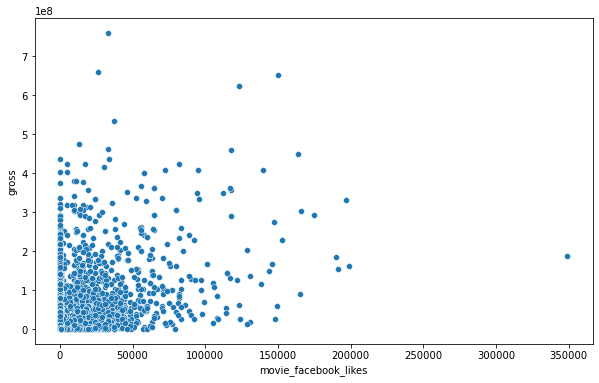

In [7]:
plt.rcParams["figure.figsize"] = (10,6)
sns.scatterplot(x ='movie_facebook_likes',y = 'gross',data = movies)

<AxesSubplot:xlabel='cast_total_facebook_likes', ylabel='gross'>

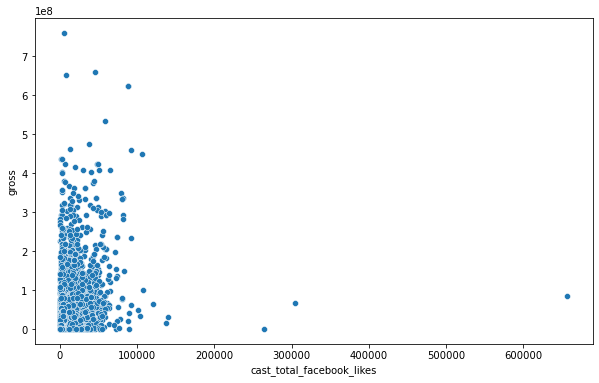

In [8]:
plt.rcParams["figure.figsize"] = (10,6)
sns.scatterplot(x ='cast_total_facebook_likes',y = 'gross',data = movies)

# Gab

In [110]:
range(genres.shape[1])

range(0, 8)

In [111]:
import numpy as np

genres = movies.genres.str.split("|", expand = True)
gen = [] 
for x in range(genres.shape[1]):
    u = genres.iloc[:, x].unique()
    gen = gen + list(u)
    
genre_list = list(pd.DataFrame(gen).iloc[:, 0].unique())
genre_list.remove(None)
genre_list

['Action',
 'Documentary',
 'Adventure',
 'Drama',
 'Animation',
 'Comedy',
 'Mystery',
 'Fantasy',
 'Crime',
 'Biography',
 'Sci-Fi',
 'Horror',
 'Romance',
 'Thriller',
 'Game-Show',
 'Family',
 'Music',
 'Western',
 'Musical',
 'Film-Noir',
 'History',
 'War',
 'Sport',
 'Reality-TV',
 'Short',
 'News']

In [112]:
genre_list = ' '.join(genre_list).replace('-','_').split()
genre_list

['Action',
 'Documentary',
 'Adventure',
 'Drama',
 'Animation',
 'Comedy',
 'Mystery',
 'Fantasy',
 'Crime',
 'Biography',
 'Sci_Fi',
 'Horror',
 'Romance',
 'Thriller',
 'Game_Show',
 'Family',
 'Music',
 'Western',
 'Musical',
 'Film_Noir',
 'History',
 'War',
 'Sport',
 'Reality_TV',
 'Short',
 'News']

In [113]:
for i in range(len(genre_list)):
    movies[str(genre_list[i])] = movies.genres.apply(lambda x: 1 if str(genre_list[i]) in x else 0)
movies

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,Music,Western,Musical,Film_Noir,History,War,Sport,Reality_TV,Short,News
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0,0,0,0,0,0,0,0,0,0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,0,0,0,0,0,0,0,0,0,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,0,0,0,0,0,0,0,0,0,0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,0,0,0,0,0,0,0,0,0,0
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,0,0,0,0,0,0,0,0,0,0
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,0,0,0,0,0,0,0,0,0,0
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,0,0,0,0,0,0,0,0,0,0


In [114]:
model = smf.ols(formula = 'gross~movie_facebook_likes+cast_total_facebook_likes+' + '+'.join([str(x) for x in genre_list]) , data = movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     80.17
Date:                Mon, 27 Feb 2023   Prob (F-statistic):          2.21e-320
Time:                        20:50:37   Log-Likelihood:                -80141.
No. Observations:                4159   AIC:                         1.603e+05
Df Residuals:                    4134   BIC:                         1.605e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3.329e+07   2.92e+06     11.385      0.000    2.76e+07     3.9e+07
movie_facebook_likes       1014.5736     44.228     22.940      0.000     927.864    1101.284
cast_total_facebook_likes   565.5752     48.998     11.543      0.000     469.513     661.637
Action                     1.825e+07   2.54e+06      7.184      0.000    1.33e+07    2.32e+07
Documentary               -2.385e+07   6.44e+06     -3.702      0.000   -3.65e+07   -1.12e+07
Adventure                  2.757e+07   2.75e+06     10.040      0.000    2.22e+07     3.3e+07
Drama                     -1.726e+07   2.23e+06     -7.733      0.000   -2.16e+07   -1.29e+07
Animation                  2.005e+07   5.03e+06      3.987      0.000    1.02e+07    2.99e+07
Comedy                    -4.862e+06   2.29e+06     -2.126      0.034   -9.35e+06   -3.79e+05
Mystery                    3.471e+06   3.22e+06      1.077      0.282   -2.85e+06    9.79e+06
Fantasy                    1.116e+07   2.95e+06      3.783      0.000    5.38e+06    1.69e+07
Crime                     -5.803e+06   2.59e+06     -2.238      0.025   -1.09e+07   -7.19e+05
Biography                 -3.408e+06      4e+06     -0.852      0.394   -1.13e+07    4.44e+06
Sci_Fi                    -4.254e-07   6.01e-07     -0.707      0.479    -1.6e-06    7.54e-07
Horror                    -1.506e+07   3.44e+06     -4.374      0.000   -2.18e+07   -8.31e+06
Romance                    4.411e+06   2.27e+06      1.940      0.052   -4.57e+04    8.87e+06
Thriller                  -3.647e+06   2.54e+06     -1.438      0.150   -8.62e+06    1.33e+06
Game_Show                 -7.178e-08   7.62e-08     -0.943      0.346   -2.21e-07    7.75e-08
Family                     1.897e+07   3.68e+06      5.158      0.000    1.18e+07    2.62e+07
Music                      4.657e+05   4.52e+06      0.103      0.918    -8.4e+06    9.33e+06
Western                   -1.756e+07   7.05e+06     -2.490      0.013   -3.14e+07   -3.73e+06
Musical                   -2.833e+06   7.05e+06     -0.402      0.688   -1.66e+07     1.1e+07
Film_Noir                  1.892e-08   1.91e-08      0.993      0.321   -1.85e-08    5.63e-08
History                   -1.094e+06   5.08e+06     -0.215      0.830   -1.11e+07    8.87e+06
War                        -3.37e+06   4.78e+06     -0.705      0.481   -1.27e+07       6e+06
Sport                      4.657e+06   4.64e+06      1.003      0.316   -4.44e+06    1.38e+07
Reality_TV                         0          0        nan        nan           0           0
Short                     -4.012e+07   4.04e+07     -0.994      0.320   -1.19e+08     3.9e+07
News                      -7.409e+05   5.71e+07     -0.013      0.990   -1.13e+08    1.11e+08
===========================================================================

In [94]:
model = smf.ols(formula = 'np.log(gross)~budget+np.log(budget)', data = movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(gross)   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     1049.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:35:02   Log-Likelihood:                -7798.6
No. Observations:                3891   AIC:                         1.560e+04
Df Residuals:                    3888   BIC:                         1.562e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.8896      0.322      5.869      0.000       1.258       2.521
budget          -1.01e-09   1.34e-10     -7.544      0.000   -1.27e-09   -7.47e-10
np.log(budget)     0.8785      0.019     45.608      0.000       0.841       0.916
==============================================================================
Omnibus:                     1037.630   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3202.066
Skew:                          -1.357   Prob(JB):                         0.00
Kurtosis:                       6.519   Cond. No.                     2.54e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

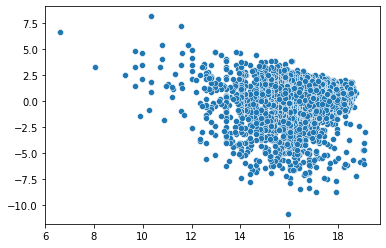

In [95]:
sns.scatterplot(x = model.fittedvalues, y = model.resid)

In [99]:
model = smf.ols('np.log(gross)~movie_facebook_likes+cast_total_facebook_likes+budget+np.log(budget)', data=movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(gross)   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     568.9
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:37:55   Log-Likelihood:                -7741.0
No. Observations:                3891   AIC:                         1.549e+04
Df Residuals:                    3886   BIC:                         1.552e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.5765      0.324      7.943      0.000       1.941       3.212
movie_facebook_likes       1.279e-05   1.38e-06      9.258      0.000    1.01e-05    1.55e-05
cast_total_facebook_likes  6.078e-06   1.56e-06      3.900      0.000    3.02e-06    9.13e-06
budget                    -1.001e-09   1.32e-10     -7.583      0.000   -1.26e-09   -7.42e-10
np.log(budget)                0.8263      0.020     41.982      0.000       0.788       0.865
==============================================================================
Omnibus:                     1037.241   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3169.582
Skew:                          -1.361   Prob(JB):                         0.00
Kurtosis:                       6.485   Cond. No.                     2.60e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

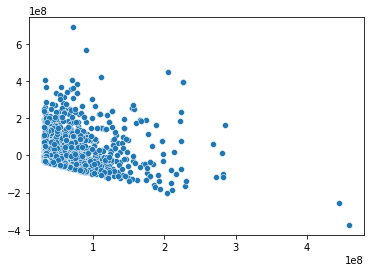

In [88]:
sns.scatterplot(x = model.fittedvalues, y = model.resid)

In [115]:
model = smf.ols('np.log(gross)~movie_facebook_likes+cast_total_facebook_likes+budget+np.log(budget)+' + '+'.join([str(x) for x in genre_list]), data=movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(gross)   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     101.3
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:55:35   Log-Likelihood:                -7657.4
No. Observations:                3891   AIC:                         1.537e+04
Df Residuals:                    3865   BIC:                         1.553e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.1222      0.368      8.489      0.000       2.401       3.843
movie_facebook_likes        1.37e-05   1.38e-06      9.909      0.000     1.1e-05    1.64e-05
cast_total_facebook_likes  6.903e-06   1.54e-06      4.490      0.000    3.89e-06    9.92e-06
budget                    -9.794e-10    1.3e-10     -7.524      0.000   -1.23e-09   -7.24e-10
np.log(budget)                0.7913      0.022     35.555      0.000       0.748       0.835
Action                        0.0389      0.081      0.479      0.632      -0.120       0.198
Documentary                  -0.3242      0.231     -1.404      0.160      -0.777       0.129
Adventure                     0.1267      0.087      1.464      0.143      -0.043       0.296
Drama                        -0.3338      0.071     -4.695      0.000      -0.473      -0.194
Animation                    -0.1522      0.157     -0.967      0.334      -0.461       0.156
Comedy                        0.1233      0.073      1.689      0.091      -0.020       0.266
Mystery                       0.1272      0.101      1.257      0.209      -0.071       0.326
Fantasy                      -0.1217      0.092     -1.323      0.186      -0.302       0.059
Crime                        -0.2002      0.082     -2.444      0.015      -0.361      -0.040
Biography                     0.2197      0.128      1.720      0.086      -0.031       0.470
Sci_Fi                     9.549e-14   9.85e-14      0.970      0.332   -9.76e-14    2.89e-13
Horror                        0.3750      0.109      3.448      0.001       0.162       0.588
Romance                       0.1586      0.073      2.186      0.029       0.016       0.301
Thriller                      0.0970      0.080      1.215      0.224      -0.060       0.254
Game_Show                 -1.252e-13   1.29e-13     -0.970      0.332   -3.78e-13    1.28e-13
Family                        0.5027      0.116      4.317      0.000       0.274       0.731
Music                         0.4430      0.149      2.972      0.003       0.151       0.735
Western                      -0.2077      0.224     -0.926      0.355      -0.648       0.232
Musical                      -0.4995      0.227     -2.200      0.028      -0.945      -0.054
Film_Noir                 -7.217e-16   6.61e-16     -1.091      0.275   -2.02e-15    5.75e-16
History                      -0.3071      0.161     -1.912      0.056      -0.622       0.008
War                          -0.5019      0.152     -3.312      0.001      -0.799      -0.205
Sport                         0.1473      0.150      0.984      0.325      -0.146       0.441
Reality_TV                         0          0        nan        nan           0           0
Short                         0.5777      1.239      0.466      0.641      

In [146]:
len(movies)

5043

In [150]:
movies2 = movies.dropna()
movies2 = movies2.reset_index()
movies2['log_gross'] = np.log(movies.gross)

In [152]:
import statsmodels.regression.linear_model as sm
from sklearn.preprocessing import PolynomialFeatures
X = movies2[['movie_facebook_likes', 'cast_total_facebook_likes', 'budget']]
Y = movies2['gross']

feat = PolynomialFeatures(3, interaction_only = False)
X = feat.fit_transform(X)
X = pd.DataFrame(data = X, columns = feat.get_feature_names_out())

model = sm.OLS(endog = Y, exog = X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                      -0.165
Model:                            OLS   Adj. R-squared:                 -0.168
Method:                 Least Squares   F-statistic:                    -66.38
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               1.00
Time:                        21:08:29   Log-Likelihood:                -73481.
No. Observations:                3756   AIC:                         1.470e+05
Df Residuals:                    3747   BIC:                         1.470e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
1                                                      2.245e-22   6.62e-23      3.390      0.001    9.47e-23    3.54e-22
movie_facebook_likes                                  -4.698e-11   3.15e-11     -1.493      0.136   -1.09e-10    1.47e-11
cast_total_facebook_likes                             -4.609e-17   1.75e-17     -2.635      0.008   -8.04e-17   -1.18e-17
budget                                                 1.147e-14   2.88e-15      3.987      0.000    5.83e-15    1.71e-14
movie_facebook_likes^2                                 1.254e-12   4.15e-13      3.020      0.003     4.4e-13    2.07e-12
movie_facebook_likes cast_total_facebook_likes         7.344e-13   2.29e-13      3.211      0.001    2.86e-13    1.18e-12
movie_facebook_likes budget                            1.446e-10   1.55e-11      9.302      0.000    1.14e-10    1.75e-10
cast_total_facebook_likes^2                            5.412e-13   1.67e-13      3.244      0.001    2.14e-13    8.68e-13
cast_total_facebook_likes budget                       1.546e-10   4.04e-11      3.826      0.000    7.54e-11    2.34e-10
budget^2                                              -3.111e-11   7.22e-12     -4.310      0.000   -4.53e-11    -1.7e-11
movie_facebook_likes^3                                -6.031e-08   6.11e-09     -9.874      0.000   -7.23e-08   -4.83e-08
movie_facebook_likes^2 cast_total_facebook_likes       9.788e-08   3.12e-08      3.132      0.002    3.66e-08    1.59e-07
movie_facebook_likes^2 budget                          1.496e-10   1.11e-11     13.448      0.000    1.28e-10    1.71e-10
movie_facebook_likes cast_total_facebook_likes^2        3.93e-08   1.23e-08      3.201      0.001    1.52e-08    6.34e-08
movie_facebook_likes cast_total_facebook_likes budget -2.175e-10   3.68e-11     -5.918      0.000    -2.9e-10   -1.45e-10
movie_facebook_likes budget^2                         -2.043e-14   2.35e-15     -8.678      0.000    -2.5e-14   -1.58e-14
cast_total_facebook_likes^3                           -3.381e-09   8.48e-10     -3.985      0.000   -5.04e-09   -1.72e-09
cast_total_facebook_likes^2 budget                     8.746e-11   2.01e-11      4.347      0.000     4.8e-11    1.27e-10
cast_total_facebook_likes budget^2                     1.023e-13   7.54e-15     13.578      0.000    8.76e-14    1.17e-13
budget^3                                               4.388e-21   8.28e-22      5.299      0.000    2.76e-21    6.01e-21
==============================================================================
Omnibus:                     1736.675   Durbin-Watson:                   0.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36786.880
Skew:                           1.699   